# Portofolio:

## Business Understanding

### Introduction

### Objectives

### Tools and Dataset Needed

### Methodology

## Data Understanding

### Data Acquisition

In [36]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def adjust(h):
    plt.figure(figsize=(16,h), dpi=300)

In [2]:
dataset = pd.read_csv('data/seblak_dataset.csv')
dataset.head()

,customer_id,transaction_date,city,customers,purchase
0,7,2023-09-23,Bekasi,member,136
1,22,2023-05-05,Depok,member,142
2,36,2023-12-16,Tangerang,member,156
3,28,2023-03-19,Bekasi,member,179
4,24,2023-01-19,Bekasi,member,164


### Data Profiling

In [3]:
# dataset info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3936 entries, 0 to 3935
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customer_id       3936 non-null   int64 
 1   transaction_date  3936 non-null   object
 2   city              3936 non-null   object
 3   customers         3936 non-null   object
 4   purchase          3936 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 153.9+ KB


In [4]:
# missing values
dataset.isnull().sum()

customer_id         0
transaction_date    0
city                0
customers           0
purchase            0
dtype: int64

In [5]:
# duplicated values
dataset.duplicated().sum()

np.int64(0)

In [6]:
# correct wrong format
dataset['transaction_date'] = pd.to_datetime(dataset['transaction_date'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3936 entries, 0 to 3935
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       3936 non-null   int64         
 1   transaction_date  3936 non-null   datetime64[ns]
 2   city              3936 non-null   object        
 3   customers         3936 non-null   object        
 4   purchase          3936 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 153.9+ KB


### Descriptive Statistics

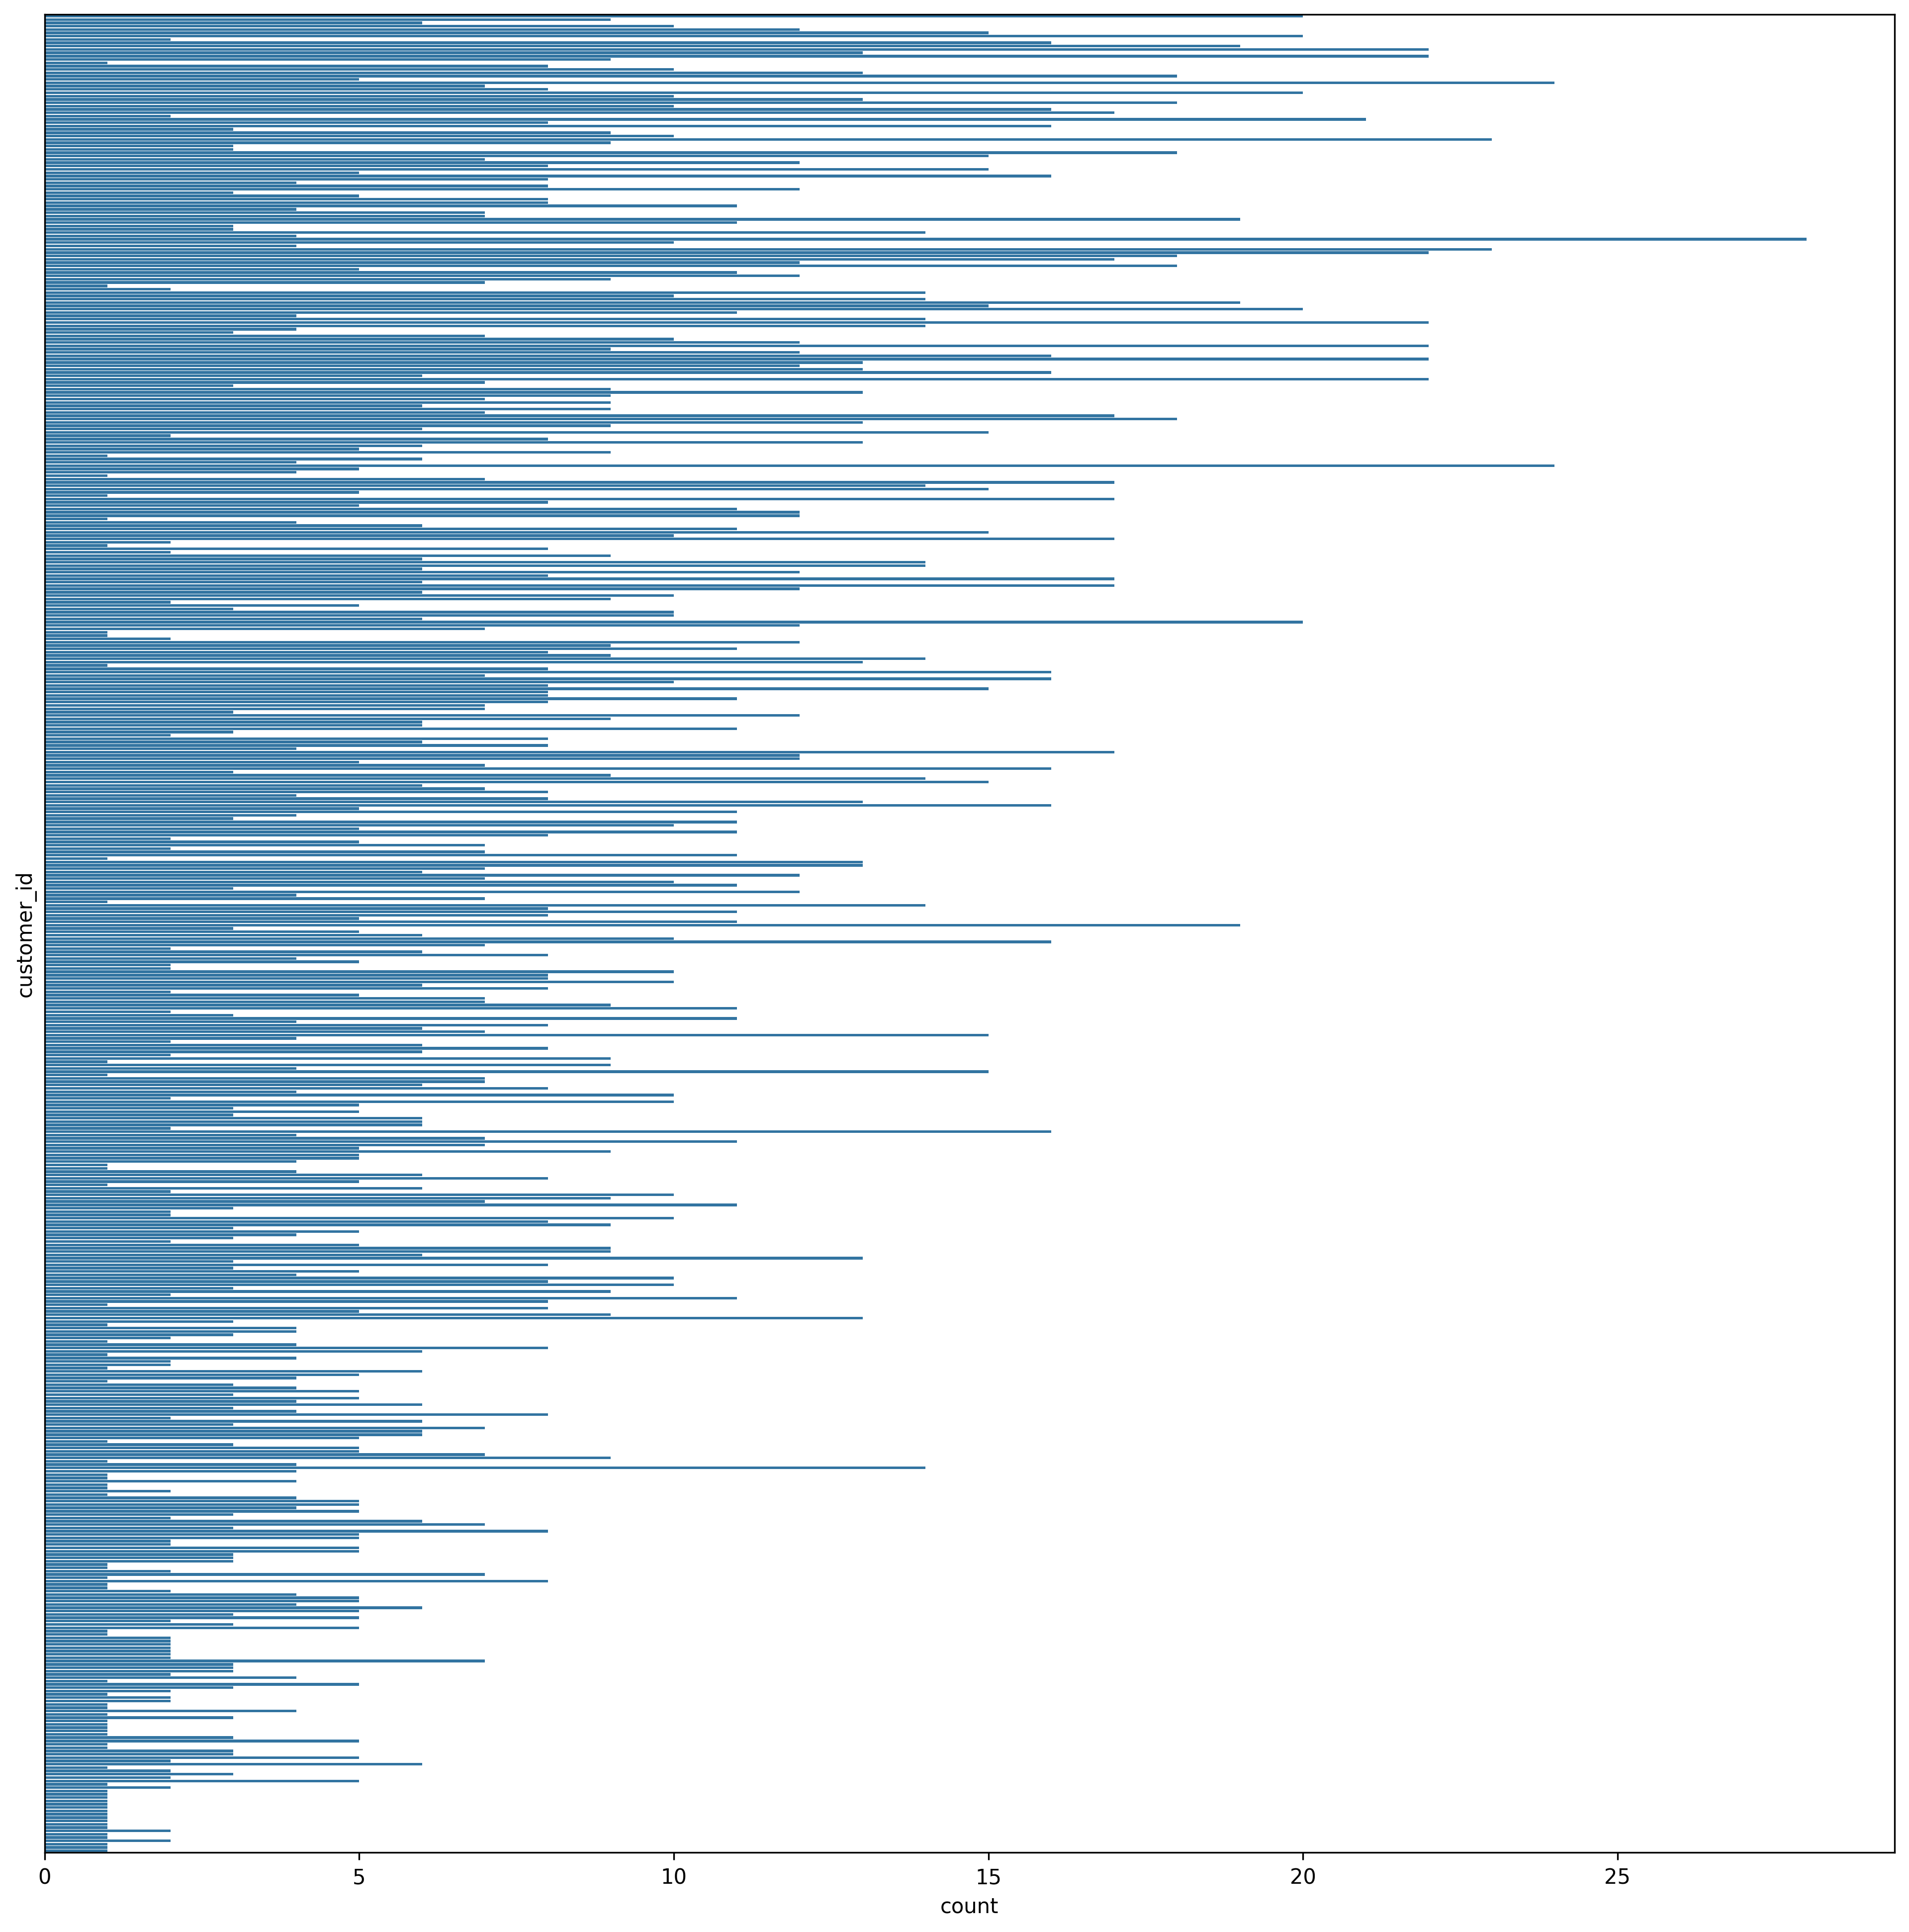

In [45]:
adjust(16)
sns.barplot(dataset.customer_id.value_counts(),orient='h')
plt.yticks([])
plt.show()

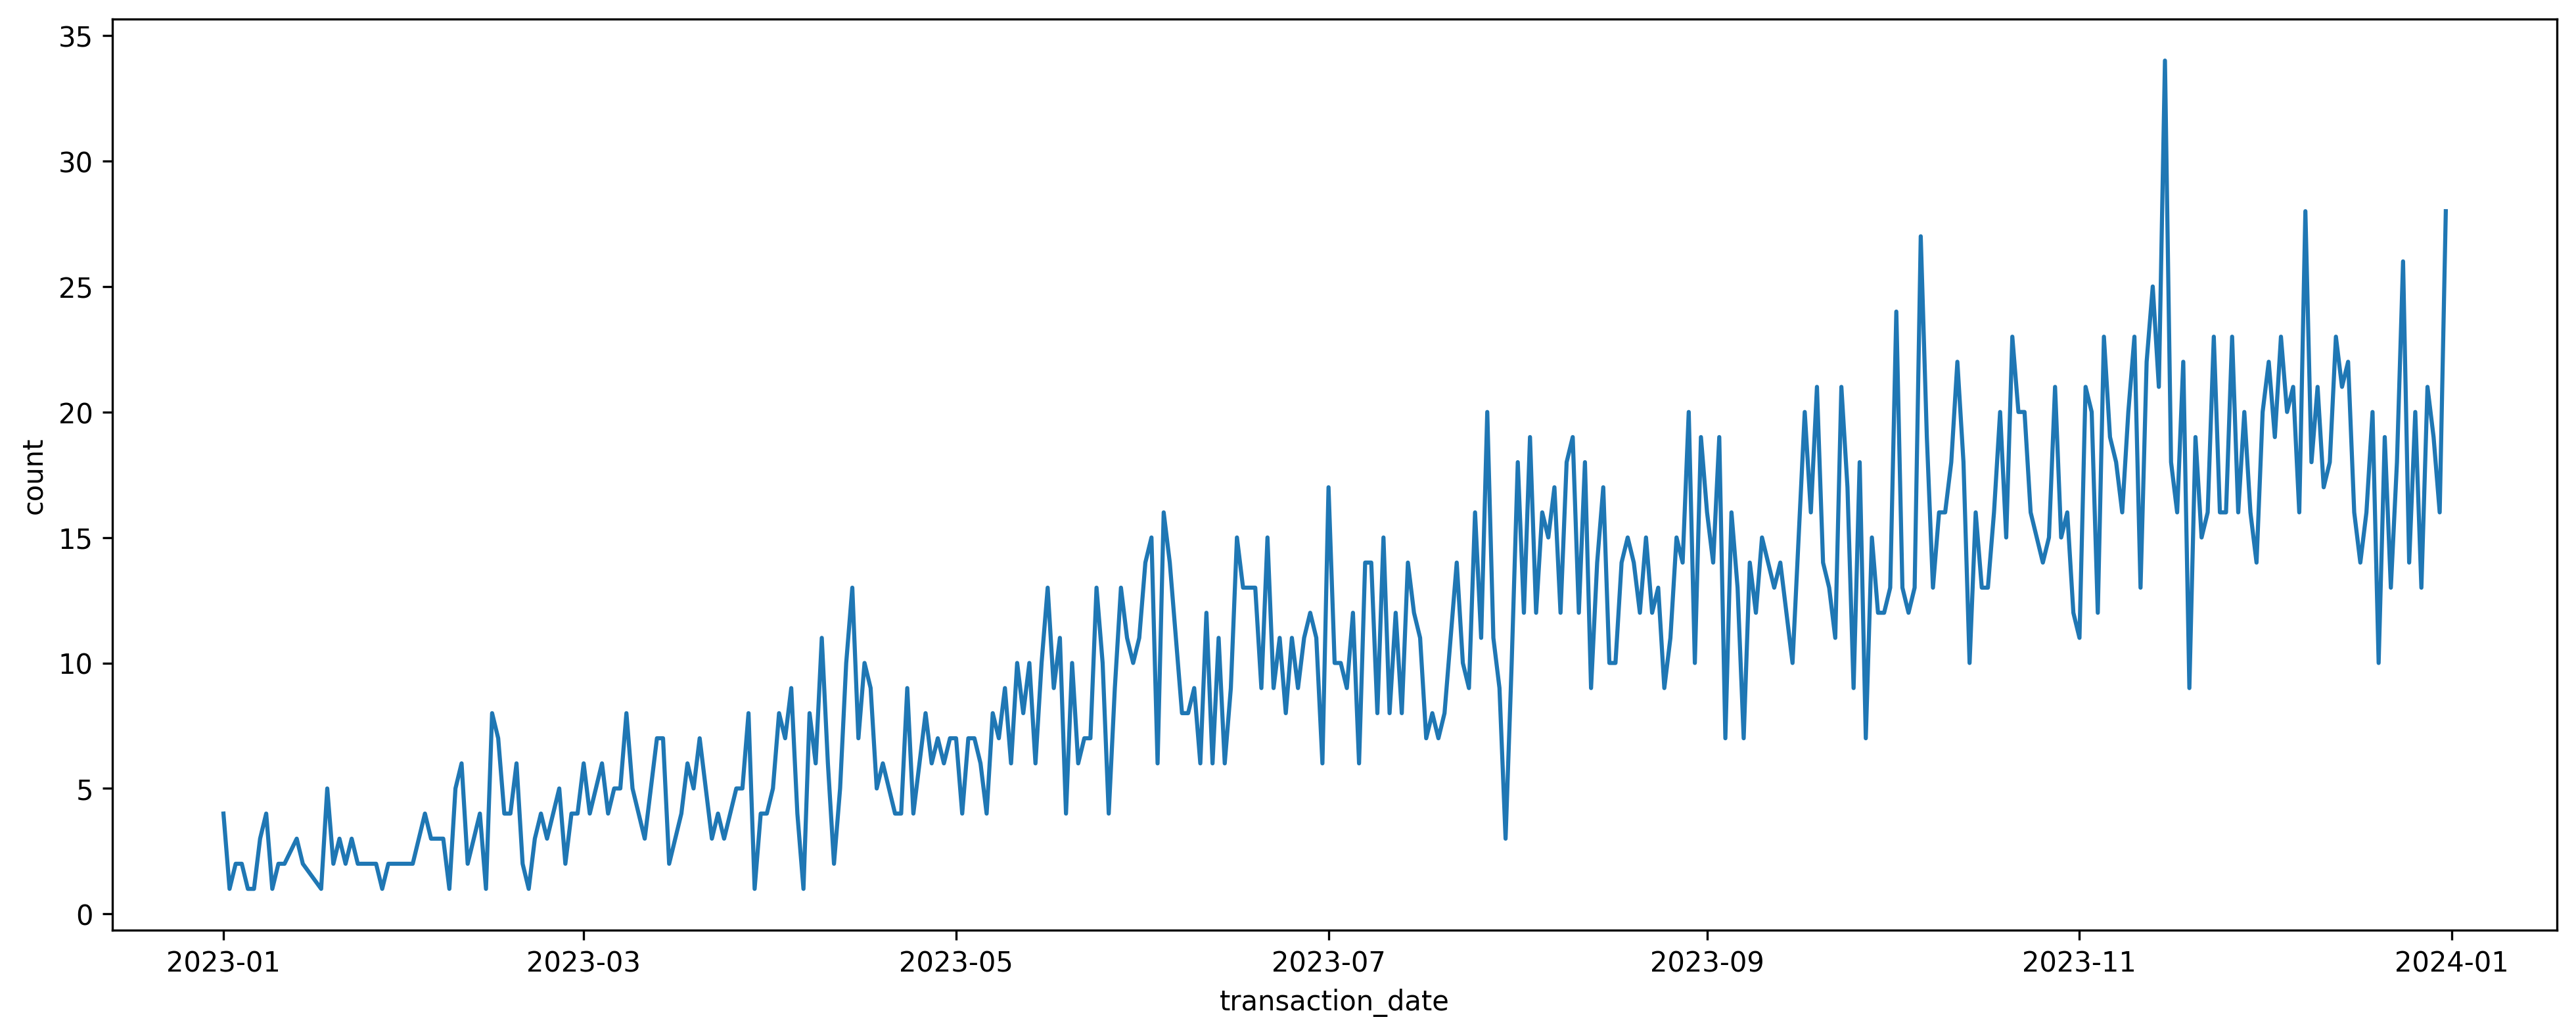

In [37]:
adjust(h=6)
sns.lineplot(dataset.transaction_date.value_counts())
plt.show()

## Data Preprocessing

In [9]:
maks = dataset.groupby('customer_id')['transaction_date'].max()
mins = dataset.groupby('customer_id')['transaction_date'].min()

In [10]:
print(maks.head(), mins.head())

customer_id
1   2023-12-28
2   2023-12-26
3   2023-11-17
4   2023-12-13
5   2023-12-15
Name: transaction_date, dtype: datetime64[ns] customer_id
1   2023-01-07
2   2023-01-18
3   2023-01-14
4   2023-01-03
5   2023-01-29
Name: transaction_date, dtype: datetime64[ns]


In [11]:
dataset_selected = pd.DataFrame({'maks': maks,
                                 'mins': mins})

In [12]:
dataset_selected.head()

,maks,mins
customer_id,,
1,2023-12-28,2023-01-07
2,2023-12-26,2023-01-18
3,2023-11-17,2023-01-14
4,2023-12-13,2023-01-03
5,2023-12-15,2023-01-29


In [13]:
def churn(maks):
    if maks > np.quantile(dataset['transaction_date'], 0.75):
        return 0
    else:
        return 1

In [14]:
dataset_selected['churn'] = dataset_selected['maks'].apply(churn)
dataset_selected.head()

,maks,mins,churn
customer_id,,,
1,2023-12-28,2023-01-07,0
2,2023-12-26,2023-01-18,0
3,2023-11-17,2023-01-14,0
4,2023-12-13,2023-01-03,0
5,2023-12-15,2023-01-29,0


In [15]:
dataset_selected['duration'] = (dataset_selected['maks'] - dataset_selected['mins'])

In [16]:
dataset_selected[dataset_selected['churn'] == 1]

,maks,mins,churn,duration
customer_id,,,,
7,2023-10-27,2023-01-14,1,286 days
8,2023-08-09,2023-03-08,1,154 days
15,2023-07-10,2023-07-10,1,0 days
16,2023-10-21,2023-02-03,1,260 days
20,2023-06-23,2023-02-11,1,132 days
...,...,...,...,...
499,2023-11-05,2023-10-01,1,35 days
502,2023-11-05,2023-11-05,1,0 days
517,2023-11-05,2023-11-04,1,1 days


## Modeling

In [17]:
from lifelines import KaplanMeierFitter, CoxPHFitter

In [18]:
kmf = KaplanMeierFitter()

In [33]:
kmf.fit(durations=dataset_selected['duration'].dt.days,
       event_observed=dataset_selected['churn'])

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 552 total observations, 441 right-censored observations>

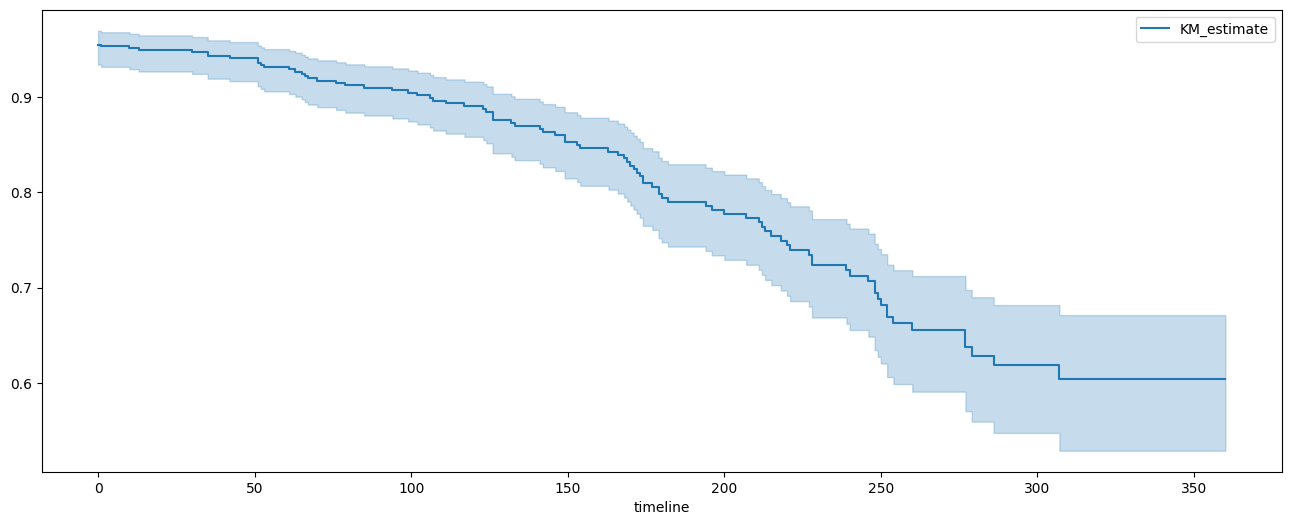

In [34]:
plt.figure(figsize=(16,6))
kmf.plot()
plt.show()

## Insights

### Interpretation and Reporting

### Action